In [2]:
import zipfile
import os

zip_file_path = '/content/sms+spam+collection.zip'
extract_dir = 'extracted_data'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Zip file extracted to: {extract_dir}")

Zip file extracted to: extracted_data


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

import re

In [4]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
df = pd.read_csv('/content/extracted_data/SMSSpamCollection', sep='\t', names=['label', 'message'])
df.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [6]:
# Converting the labels to numerical
df['label'] = df['label'].map({'ham':0, 'spam':1})
df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [7]:
df.isna().sum()

,0
label,0
message,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [9]:
df['label'].value_counts()

,count
label,
0,4825
1,747


Text(0.5, 1.0, 'Labels Distribution')

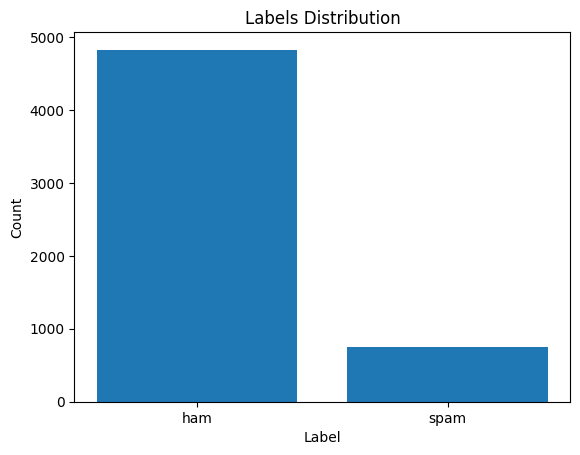

In [10]:
import matplotlib.pyplot as plt

plt.bar(['ham', 'spam'], df['label'].value_counts())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Labels Distribution')

## Preprocessing the Text Data

In [11]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, use_stemming=True):
  # Convert to lower case
  text = text.lower()
  # Remove punctuation and special characters
  text = re.sub(r'[^a-z0-9\s]', '', text)

  # Tokenizing text
  tokens = nltk.word_tokenize(text)

  # Removing Stop Words
  tokens = [word for word in tokens if word not in stop_words]

  # Using Stemming or Lemmatization
  if use_stemming:
    tokens = [stemmer.stem(word) for word in tokens]
  else:
    # Use Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return ' '.join(tokens)

df['processed_text'] = df['message'].apply(preprocess_text, use_stemming=False) # Using Lemmatization instead of Stemming
df.head(10)

,label,message,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though
5,1,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling 3 week word back id like f...
6,0,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent
7,0,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,1,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,1,Had your mobile 11 months or more? U R entitle...,mobile 11 month u r entitled update latest col...


## Feature Extraction

In [12]:
# CountVectorizer Implementaion: Uses Bag-of-Words technique
count_vectorizer = CountVectorizer(max_features=5000)
X_countvec = count_vectorizer.fit_transform(df['processed_text']).toarray()

# TF-IDF Vectorizer Implementation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text']).toarray()

# Can use any of them, however, Tfidf has better performance, therefore proceeding with Tfidf output
y = df['label']
# X_tfidf

# Standard Model Evaluation Method (train_test-split...)

## Splitting the Data

In [13]:
# Using TF-IDF Vectorizer output
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [52]:
# Using CountVectorizer Output
X_train_countVec, X_test_countVec, y_train_countVec, y_test_countVec = train_test_split(X_countvec, y, test_size=0.2, random_state=42)

## Model Training (NaiveBayes Classifier)

In [50]:
# TF-IDF
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [53]:
# CountVectorizer
model_countVec = MultinomialNB()
model_countVec.fit(X_train_countVec, y_train_countVec)

MultinomialNB()

## Model Evaluation

In [51]:
# TF-IDF
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.979372197309417
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [54]:
# CountVectorizer
y_pred_countVec = model_countVec.predict(X_test_countVec)

accuracy_countVec = accuracy_score(y_test_countVec, y_pred_countVec)
print(f"Accuracy: {accuracy_countVec}")

print('Classification Report:')
print(classification_report(y_test_countVec, y_pred_countVec))

Accuracy: 0.9874439461883409
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.95      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



## Testing on New Input Data

In [57]:
new_message = "Congratulations! You've won a FREE iPhone. Click here now!"
preprocessed_message = preprocess_text(new_message, use_stemming=False)
vectorized_messaged = tfidf_vectorizer.transform([preprocessed_message])
prediction = model.predict(vectorized_messaged)

new_pred = ''
if prediction[0] == 0:
  new_pred = 'Ham'
else:
  new_pred = 'Spam'

print(f"The model predicted message to be: {new_pred} and it is 'Spam'")

The model predicted message to be: Spam and it is 'Spam'


# Implementing Stratified K-Fold Cross Validation

In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_f1 = []
for fold, (train_index, test_index) in enumerate(skf.split(X_tfidf, y)):
  X_train_fold, X_test_fold = X_tfidf[train_index], X_tfidf[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

  model_fold = MultinomialNB()
  model_fold.fit(X_train_fold, y_train_fold)

  y_pred_fold = model_fold.predict(X_test_fold)
  accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
  f1_fold = classification_report(y_test_fold, y_pred_fold, output_dict = True)
  fold_f1.append(f1_fold['1']['f1-score'])
  fold_accuracies.append(accuracy_fold)


  print(f"Fold {fold + 1} Accuracy: {accuracy_fold}")
  print(f"Fold {fold + 1} F1-Score: {f1_fold['1']['f1-score']}\n")

average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
average_f1 = sum(fold_f1) / len(fold_f1)
print(f"\nAverage Accuracy: {average_accuracy}")
print(f"Average F1-Score: {average_f1}")


Fold 1 Accuracy: 0.9811659192825112
Fold 1 F1-Score: 0.9247311827956989

Fold 2 Accuracy: 0.967713004484305
Fold 2 F1-Score: 0.8646616541353384

Fold 3 Accuracy: 0.9766606822262118
Fold 3 F1-Score: 0.9044117647058824

Fold 4 Accuracy: 0.9694793536804309
Fold 4 F1-Score: 0.8712121212121212

Fold 5 Accuracy: 0.9730700179533214
Fold 5 F1-Score: 0.8880597014925373


Average Accuracy: 0.973617795525356
Average F1-Score: 0.8906152848683156


# Creating Final Deplpoyable model on entire dataset

In [21]:
model_final = MultinomialNB()
model_final.fit(X_tfidf, y)

y_final_pred = model_final.predict(X_tfidf)
report = classification_report(y, y_final_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4825
           1       1.00      0.87      0.93       747

    accuracy                           0.98      5572
   macro avg       0.99      0.94      0.96      5572
weighted avg       0.98      0.98      0.98      5572



# Testing the final model on new data

In [23]:
new_message_ham = "Hey, let's meet tomorrow at 2 PM for coffee."
processed_new_message_ham = preprocess_text(new_message_ham, use_stemming=False)
vectorized_new_message_ham = tfidf_vectorizer.transform([processed_new_message_ham]).toarray()
prediction_ham = model_final.predict(vectorized_new_message_ham)

new_pred = ''
if prediction_ham[0] == 0:
  new_pred = 'Ham'
else:
  new_pred = 'Spam'

print(f"The model predicted message to be: {new_pred} and it is 'Ham'")

The model predicted message to be: Ham and it is 'Ham'


In [24]:
new_message = "Congratulations! You've won a FREE iPhone. Click here now!"
preprocessed_message = preprocess_text(new_message, use_stemming=False)
vectorized_messaged = tfidf_vectorizer.transform([preprocessed_message])
prediction = model_final.predict(vectorized_messaged)

new_pred = ''
if prediction[0] == 0:
  new_pred = 'Ham'
else:
  new_pred = 'Spam'

print(f"The model predicted message to be: {new_pred} and it is 'Spam'")

The model predicted message to be: Spam and it is 'Spam'
